# Simple Convolutional Neural Network

Here's a very simple CNN using TensorFlow. We'll predict the MNIST dataset.

In [1]:
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

## Get the MNIST data

In [2]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

In [3]:
print(f'The shape of the input images is: {x_train.shape}')

The shape of the input images is: (60000, 28, 28)


In [4]:
class_names = np.unique(y_train)
num_classes = len(class_names)

print(f'There are {num_classes} classes: {class_names}')

There are 10 classes: [0 1 2 3 4 5 6 7 8 9]


## The shape of the MNIST images is H = 28, W = 28, and 1 Channel (Greyscale)

In [5]:
input_shape = (x_train.shape[1], x_train.shape[2], 1)  # Single channel

## Define the TensorFlow model

### Define the input layer for the MNIST images

In [6]:
inputs = tf.keras.layers.Input(shape=input_shape, name='input_images')

### Define the 1st convolutional layer

We'll use 3x3 filters/kernels in this layer. 

Since the input tensor only has 1 channel, then the actual filter/kernel shape is (3 x 3 x 1). 

Note there is also a *bias* term that gets added. So there are 3 x 3 x 1 + 1 = 10 numbers in each filter/kernel. 

We'll create 15 filters/kernels. So there is a total of 10 x 15 = 150 weights we will learn. 

We'll use **'same'** padding which automatically pads to make sure that the output tensor has the same height and width as the input tensor. 

We'll also apply a [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation to the output.


In [7]:
conv1 = tf.keras.layers.Conv2D(filters=15, 
                               kernel_size=(3,3), 
                               padding='same', 
                               activation='relu', 
                               name='ernie')(inputs)

### Define the 2nd convolutional layer

We'll use 5x5 filters/kernels in this layer. 

The input tensor to this layer is the 1st convolutional layer (conv1). So there are 15 channels in that tensor (28 x 28 x 15). Therefore, the actual filter/kernel shape is (5 x 5 x 15). 

Note there is also a *bias* term that gets added. So there are 5 x 5 x 15 + 1 = 376 numbers in the filter. 

We'll create 37 filters/kernels. Therefore, we ahve 376 x 37 = 13912 total weights to learn in this layer. 

We'll use **'valid'** padding which does not pad the image. Hence we'll lose 2 pixels on the border (so 4 pixels in height and 4 in width). So the height and width go from 28 x 28 to 24 x 24.

The formula for the output shape is:

`((W−K+2P)/S)+1`

where W = original width, K = kernel size, P is the pad size, and S is the stride (here just 1).

We'll also apply a [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) activation to the output.

In [8]:
conv2 = tf.keras.layers.Conv2D(filters=37, 
                               kernel_size=(5,5), 
                               padding='valid', 
                               activation='relu', 
                               name='bert')(conv1)

### Define a Pooling Layer

We'll use a 2x2 pooling operation in this layer. So the maximum pixel are output from a sliding 2x2 window. The output tensor shape drops in half for each dimensions (12 x 12 x 37).

In [9]:
pool1 = tf.keras.layers.MaxPool2D(pool_size=(2,2), name='cookie')(conv2)

### Define the 3rd and 4th convolutional layers

In [10]:
conv3 = tf.keras.layers.Conv2D(filters=6, 
                               kernel_size=(3,3), 
                               padding='same', 
                               activation='relu', 
                               name='zoe')(pool1)

In [11]:
conv4 = tf.keras.layers.Conv2D(filters=4, 
                               kernel_size=(3,3), 
                               padding='same', 
                               activation='relu', 
                               name='elmo')(pool1)

### Concatenate the 3rd and 4th convolutional layers

We can concatenate these so long as they have the same height and width. There are 6 channels in conv3 and 4 channels in conv4. So the concatentation will have 6 + 4 = 10 channels in the output tensor.

In [12]:
concat1 = tf.keras.layers.Concatenate()([conv3, conv4])

### Flatten the concat1 layer

Just turn it from matrix Height x Width x Channels into vector 1 x (Height x Width x Channels).

So it goes from as size of 12 x 12 x 10 to a size of 1440 x 1. 

Note that there are no trainable parameters here. It's just a reshaping of the tensor.

In [13]:
flat1 = tf.keras.layers.Flatten()(concat1)

### Output our prediction

We'll have num_classes (10) outputs. The output that has the greatest number is the prediction. So if the 3rd output of the 10 is the greatest number, then the output prediction is class 3.

The number of trainable weights is (1440 + 1 for the bias term) x 10 classes = 14410 weights.

In [14]:
prediction = tf.keras.layers.Dense(units=num_classes, activation='softmax', name='prediction')(flat1)

### Define the model 

We'll define our input and output layers. (Note: We can define multiple input and output layers if we desire.)

In [15]:
model = tf.keras.models.Model(inputs=[inputs], outputs=[prediction], name='sesame_cnn')

### Print the model topology

Let's examine the layers of our model. Check the `Param #` column to verify that the numbers match the trainable weights from the layer that we calculated previously.

In [16]:
model.summary(line_length=120)

Model: "sesame_cnn"
________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
input_images (InputLayer)              [(None, 28, 28, 1)]        0                                                     
________________________________________________________________________________________________________________________
ernie (Conv2D)                         (None, 28, 28, 15)         150           input_images[0][0]                      
________________________________________________________________________________________________________________________
bert (Conv2D)                          (None, 24, 24, 37)         13912         ernie[0][0]                             
________________________________________________________________________________________________________________________
cookie (MaxP

### Define our loss function

We want to change the trainable weights so that they continue to minimize the loss function. If we get the loss to 0, then it means that all predictions are correct.

In [17]:
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

### Compile the TensorFlow model

Compiling adds the SGD optimizer, loss function(s), and evaluation metric(s) to the model object.

In [18]:
model.compile(optimizer='adam',
              loss=loss_function,
              metrics=['accuracy'])

### Fit the CNN model to the training data (aka train the model)

We'll go for 4 epochs. An epoch is one pass through the training data. We have 60k images in the training data. So we'll train for a total of 4 x 60k = 240k training images. We'll use 14 images per batch.

In [19]:
history = model.fit(x=x_train, 
                    y=y_train,
                    epochs=4,
                    batch_size=14,
                    validation_data=(x_test, y_test))

Epoch 1/4
4286/4286 [==============================] - 36s 7ms/step - loss: 0.2738 - accuracy: 0.9162 - val_loss: 0.0452 - val_accuracy: 0.9865
Epoch 2/4
4286/4286 [==============================] - 19s 4ms/step - loss: 0.0519 - accuracy: 0.9840 - val_loss: 0.0371 - val_accuracy: 0.9868
Epoch 3/4
4286/4286 [==============================] - 19s 4ms/step - loss: 0.0333 - accuracy: 0.9895 - val_loss: 0.0323 - val_accuracy: 0.9909
Epoch 4/4
4286/4286 [==============================] - 19s 4ms/step - loss: 0.0238 - accuracy: 0.9918 - val_loss: 0.0288 - val_accuracy: 0.9913


### The model is now trained

Let's look at how the loss decreases (hopefully) at each epoch.

In [27]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


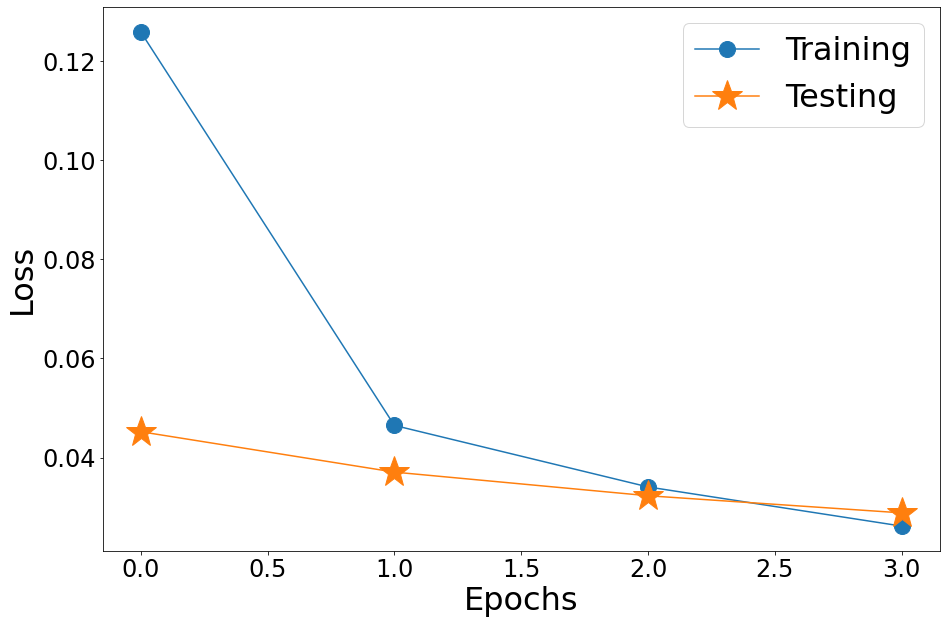

In [44]:
plt.figure(figsize=(15,10))
plt.plot(history.history['loss'], '.-', markersize=32);
plt.plot(history.history['val_loss'], '*-', markersize=32);
plt.xlabel('Epochs', fontsize=32);
plt.ylabel('Loss', fontsize=32);
plt.legend(['Training', 'Testing'], fontsize=32);
plt.xticks(fontsize=24);
plt.yticks(fontsize=24);

### Check the predictions

Let's see how accurate it is on the test dataset.

In [20]:
metrics = model.evaluate(x_test, y_test)

313/313 [==============================] - 6s 11ms/step - loss: 0.0288 - accuracy: 0.9913


In [21]:
print(f'The final model has an average loss of {metrics[0]:.4f}')
print(f'The final model is {metrics[1]*100:.2f}% accurate on average')

The final model has an average loss of 0.0288
The final model is 99.13% accurate on average


### Plot some examples

Let's plot some test examples and the prediction of the trained model.

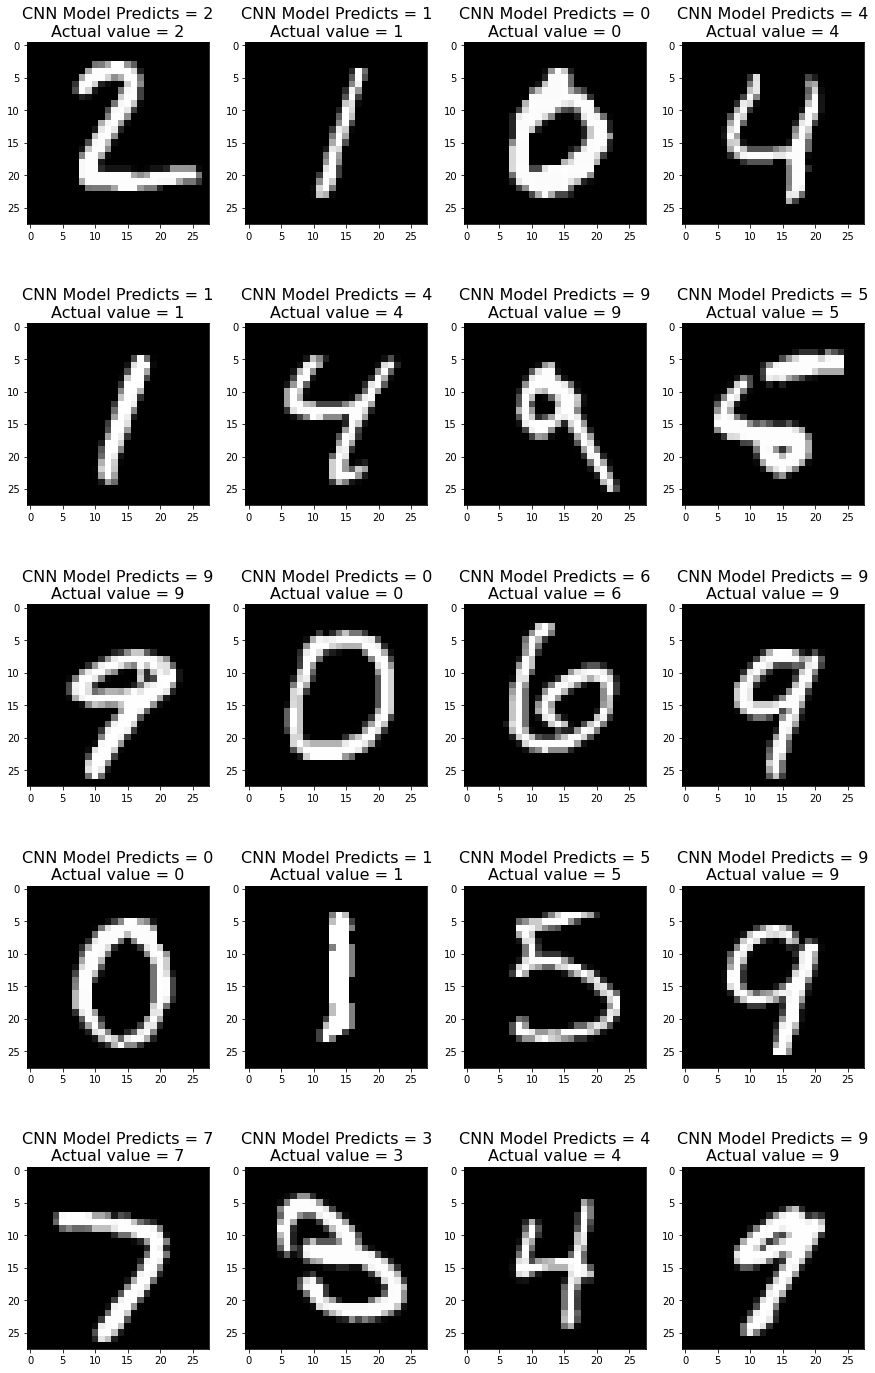

In [50]:
plt.figure(figsize=(15, 25))

rows=5
columns=4

for idx in range(1, (rows*columns)+1):
    
    actual_class = y_test[idx]
    input_image = x_test[[idx], :, :]

    predict_class = np.argmax(model.predict(input_image))

    plt.subplot(rows, columns, idx)

    plt.imshow(np.squeeze(input_image), cmap='gray')
    plt.title(f'CNN Model Predicts = {predict_class}\nActual value = {actual_class}', fontsize=16)
        
        
plt.savefig('predictions.png', dpi=600, bbox_inches='tight', pad_inches=0);

### Save the model to use later

In [55]:
# Save to HDF5 file called 'simple_cnn.h5'
model.save('simple_cnn.h5');

![cnn_topology](simple_cnn_topology.png)